## Importing neccessary liberaries

In [1]:
import matplotlib.pyplot as plt
 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D,  Dense, Dropout,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import cv2
from tensorflow.keras.utils import img_to_array

import warnings
warnings.filterwarnings('ignore')

___________________________________________________________________________________________
## Seting image size, batch size and number of emotions (classes)

In [2]:
IMAGE_SIZE = (75, 75)
BATCH_SIZE = 128
NUM_CLASSES = 7

Importing the Dataframe in which each image's name and label are stored

In [3]:
df=pd.read_csv('Datasets/AffectNet-HQ/labels.csv')

#dropping the disgust class 
df['label']=df['label'].replace({'disgust': np.nan}) 
df.dropna(inplace=True)
df=df.sample(frac=1).reset_index(drop=True)

___________________________________________________________________________________________
## Preparing ImageDataGenerator with the image augmentations needed:
rescaling,horizontal flip and rotation

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 rotation_range=15,
                                 fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255.)

_____________________________________________________________________________________________
## Importing the images from DataFrame using the previously inisialized Image Data Generators

In [5]:



train_generator=train_datagen.flow_from_dataframe(
dataframe=df[:24000],
directory="Datasets/AffectNet-HQ/",
x_col="pth",
y_col='label',
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=IMAGE_SIZE,
color_mode='rgb')


valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[20000:],
directory="Datasets/AffectNet-HQ/",
x_col="pth",
y_col='label',
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=IMAGE_SIZE,
color_mode='rgb')


Found 24000 validated image filenames belonging to 7 classes.
Found 7226 validated image filenames belonging to 7 classes.


__________________________________________________________________________
## Ploting images samples with their corrosponding classification

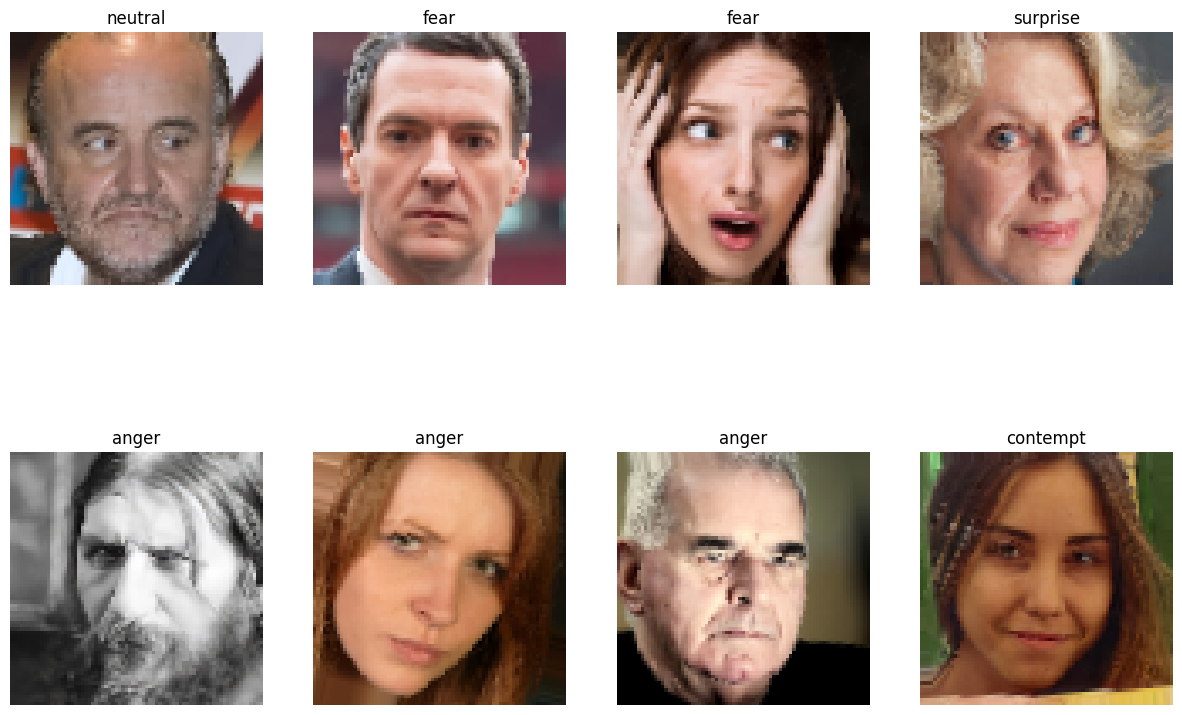

In [6]:
x,y = next(train_generator)
x.shape
classes_names=list(train_generator.class_indices.keys())

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i])
        plt.title(classes_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

_______________________________________________________________________________________________
## Building the model 
<ol>
  <li>Inisialize the model InceptionResNetV2 with random weights and without inclouding the top layes as we will be adding them later to costumize them </li>
  <li>make InceptionResNetV2 as we didn't include the 'imagenet' weights</li>
  <li>now inisialize our model as Sequencial </li>
  <li>add InceptionResNetV2 as a base model for our model</li>
  <li>add droupout layer </li>
  <li> add a BatchNormalization layer to reducing the internal covariate shift. </li>
  <li>add GlobalAveragePooling2D layer which applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged </li>
  <li>add droupout layer </li>
  <li> add a Dense layer (fully connected) with 64 neurons </li>
  <li>add droupout layer </li>
  <li> add a Dense layer with 64 neurons </li>
  <li>add droupout layer </li>
  <li> add a Dense layer with 64 neurons </li>
  <li>add droupout layer </li>
  <li>add a Dense layer with softmax activation function (since we are trying to do multiclass classification) with a neurone for each class (NUM_CLASSES) which is 7 in this case </li>
</ol>


In [7]:
base_model = applications.InceptionResNetV2(
                     include_top=False,
                     weights=None,
                     input_shape=(*IMAGE_SIZE, 3))
 
base_model.trainable=True

 
model =Sequential()
model.add(base_model)
model.add(Dropout(0.5))     
model.add(BatchNormalization(renorm=True))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


## Compile the model with categorical_crossentropy as the loss function since it is a multiclass classification model

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0005),loss='categorical_crossentropy', metrics = ['accuracy'])

_______________________________________________________________________________________________
## Add an early stopping to restore best weights and stop the training if the accuracy stopped improving after 5 epochs

In [9]:
early = tf.keras.callbacks.EarlyStopping( patience=7,
                                          min_delta=0.001,
                                          restore_best_weights=True)

_______________________________________________________________________________________________
## Add an early stopping to restore best weights and stop the training if the accuracy stopped improving after 10 epochs

In [10]:
history = model.fit(train_generator,
					validation_data=valid_generator,
					epochs=25,
					callbacks=[early])

Epoch 1/25
188/188 [==============================] - 1606s 8s/step - loss: 1.9936 - accuracy: 0.1778 - val_loss: 1.9517 - val_accuracy: 0.1614
Epoch 2/25
188/188 [==============================] - 1597s 8s/step - loss: 1.7924 - accuracy: 0.2817 - val_loss: 1.8019 - val_accuracy: 0.2888
Epoch 3/25
188/188 [==============================] - 1591s 8s/step - loss: 1.5880 - accuracy: 0.3783 - val_loss: 1.5730 - val_accuracy: 0.3901
Epoch 4/25
188/188 [==============================] - 1612s 9s/step - loss: 1.4522 - accuracy: 0.4334 - val_loss: 1.3902 - val_accuracy: 0.4673
Epoch 5/25
188/188 [==============================] - 1613s 9s/step - loss: 1.3569 - accuracy: 0.4770 - val_loss: 1.2808 - val_accuracy: 0.5163
Epoch 6/25
188/188 [==============================] - 1616s 9s/step - loss: 1.2786 - accuracy: 0.5063 - val_loss: 1.2954 - val_accuracy: 0.4958
Epoch 7/25
188/188 [==============================] - 1589s 8s/step - loss: 1.2277 - accuracy: 0.5389 - val_loss: 1.2810 - val_accuracy:

________________________________________________________________________________
## Plot Training and Validation accurarcy diagram

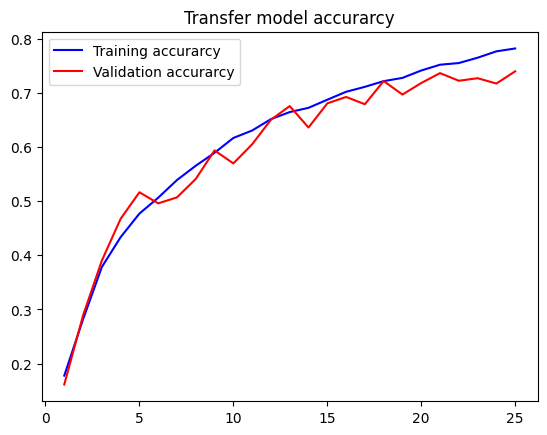

<Figure size 640x480 with 0 Axes>

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Transfer model accurarcy')
plt.legend()
plt.figure()
plt.show()

________________________________________________________________________________
## Plot Training and Validation accurarcy diagram

57/57 [==============================] - 164s 3s/step - loss: 0.7267 - accuracy: 0.7397
accuracy: 73.97%


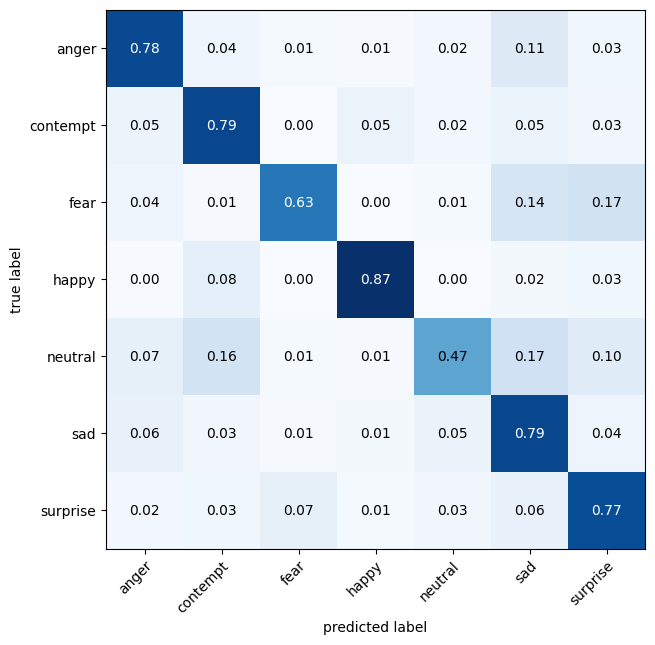

In [12]:
scores = model.evaluate(valid_generator, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# model.save('expression.model')


y_pred=np.empty((BATCH_SIZE,))
y_true=np.empty((BATCH_SIZE,))
for i in range(len(valid_generator)):
    y_pred_temp = model.predict(valid_generator[i][0],verbose=0)
    y_pred_temp = np.array([np.argmax(x) for x in y_pred_temp])
    y_pred=np.append(y_pred,y_pred_temp)
    y_true_temp=np.array([np.argmax(x) for x in valid_generator[i][1]])
    y_true=np.append(y_true,y_true_temp) 
cm = confusion_matrix(y_true[BATCH_SIZE:], y_pred[BATCH_SIZE:])

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=classes_names,
                                figsize=(NUM_CLASSES, NUM_CLASSES))

fig.show()

___________________________________________________________________________________________
## Extract faces from an image and applying the model to predict the emotions 

Number of detected faces: 3
1/1 [==============================] - 1s 624ms/step


(-0.5, 310.5, 191.5, -0.5)

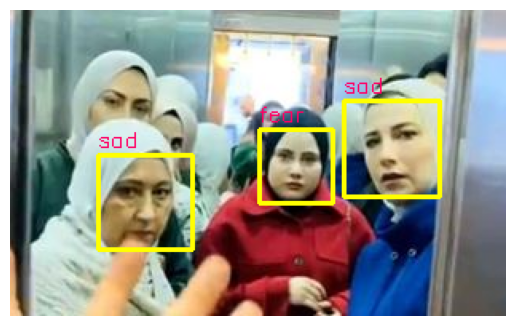

In [13]:
# read the input image
img = cv2.imread('aya.jpg')

# convert to grayscale of each frames
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# read haacascade to detect faces in input image
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# detects faces in the input image
faces = face_cascade.detectMultiScale(gray, 1.1, 2)
print('Number of detected faces:', len(faces))
# loop over all the detected faces
for (x,y,w,h) in faces:
   fc = img[y:y+h, x:x+w]
   roi = cv2.resize(fc, IMAGE_SIZE)
   roi = img_to_array(roi)  # Transforming image to array
   roi = roi / 255  # Normalizing Image
   roi = np.expand_dims(roi, axis=0)
   pred_im = model.predict(roi)
   text_idx=np.argmax(pred_im)
   text=classes_names[text_idx]
   cv2.putText(img, text, (x, y-5),
       cv2.FONT_HERSHEY_SIMPLEX, 0.45, (100, 0, 255), 1)
   # To draw a rectangle around the detected face  
   cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)

# Display an image in a window
plt.imshow(img[:,:,::-1])
plt.axis('off')